In [195]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

In [196]:
with open('Samples/test/TPGM_fit_test/likelihoods.pkl', 'rb') as f:
    likelihoods = pkl.load(f)

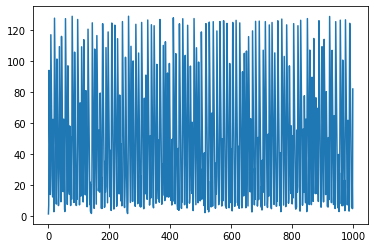

In [197]:
plt.plot(likelihoods[1])

In [198]:
samples = np.load('Samples/test/samples.npy')
print(samples.shape)

(60, 10)


In [199]:
def soft_threshold(x, threshold):
    """
    Applies the soft thresholding operation to vector x with the specified threshold.

    :param x:
    :param threshold:
    :return:
    """
    x_plus = x - threshold
    x_minus = -x - threshold
    return x_plus * (x_plus > 0) - x_minus * (x_minus > 0)


In [200]:
x = np.array([1, 3, 4, 2, -1, -3])
print(soft_threshold(x, 2))

[ 0  1  2  0  0 -1]
